In [2]:
import numpy as np 
import pandas as pd 
#df = pd.read_csv("../Analyzed_Games/twic1556_15_analyzed.csv")
#df=pd.read_csv("../Analyzed_Games/test2_15_analyzed.csv")
#df= pd.read_csv("../Analyzed_Games/twic920_15_analyzed.csv")


# Cleaning data (use Dorian's cleaning function instead of this for better results)

In [4]:
initial_game_count = df['GameID'].nunique()

# Step 1: Identify GameIDs with valid 'Result'
valid_result_games = df[df['Result'].isin(['1-0', '0-1', '1/2-1/2'])]['GameID'].unique()

# Step 2: Identify GameIDs with no missing 'WhiteFideId' or 'BlackFideId'
fide_valid_games = df.dropna(subset=['WhiteFideId', 'BlackFideId'])['GameID'].unique()

# Step 3: Find the intersection of valid games
valid_games = np.intersect1d(valid_result_games, fide_valid_games)

# Step 4: Filter the DataFrame to include only valid games
df_cleaned = df[df['GameID'].isin(valid_games)].copy()

# Record the final number of unique games
final_game_count = df_cleaned['GameID'].nunique()

# Calculate the number of games removed
removed_games = initial_game_count - final_game_count

# Reset the index
df_cleaned = df_cleaned.reset_index(drop=True)

# Create a mapping from old GameID to new sequential GameID
unique_games = df_cleaned['GameID'].unique()
game_id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_games, start=1)}

# Apply the mapping to fix 'GameID'
df_cleaned['GameID'] = df_cleaned['GameID'].map(game_id_mapping)

# Save the cleaned DataFrame to a new CSV file (optional)
# df_cleaned.to_csv("../huge_analyzed_games/combined_analyzed_games_cleaned.csv", index=False)

# Print the number of games removed
print(f"Number of games removed: {removed_games}")

Number of games removed: 11


# Creating Winning Chances column 

In [5]:

df['Evaluation'] = df['Evaluation'].astype(str).str.strip()
df['PlayerToMove'] = np.where(df['MoveNumber'] % 2 == 1, 'White', 'Black')

# Function to convert 'Evaluation' to 'New_evaluations'
def convert_evaluation(row):
    eval_str = row['Evaluation']
    
    if eval_str in ['+M0', '-M0', 'M0']:
        return 0.0  # Mate in 0 moves
    elif eval_str.startswith('+M') or (eval_str.startswith('M') and not eval_str.startswith('-M')):
        return 20.0  # White can mate
    elif eval_str.startswith('-M'):
        return -20.0  # Black can mate
    else:
        # Try to convert the evaluation to a float
        try:
            eval_float = float(eval_str)
            return eval_float  # Numeric evaluation remains the same
        except ValueError:
            return np.nan  # Unable to parse evaluation

# Apply the function to create 'New_evaluations' column
df['New_evaluations'] = df.apply(convert_evaluation, axis=1)

In [6]:
# Map 'Result' to outcome from White's perspective
def get_outcome(result):
    if result == '1-0':
        return 'Win'    # White won
    elif result == '0-1':
        return 'Loss'   # White lost
    elif result == '1/2-1/2':
        return 'Draw'   # Draw
    else:
        return None     # Exclude other results
    
    
def calculate_chances(df, lower_eval, upper_eval):
    # Filter positions where 'New_evaluations' is between lower_eval and upper_eval
    positions_in_range = df[(df['New_evaluations'] >= lower_eval) & (df['New_evaluations'] <= upper_eval)].copy()
    
    # Get unique GameIDs where this occurs
    games_in_range = positions_in_range['GameID'].unique()
    
    # Get the results of these games
    game_results = df[df['GameID'].isin(games_in_range)][['GameID', 'Result']].drop_duplicates()
    
    # Apply the mapping
    game_results['Outcome'] = game_results['Result'].apply(get_outcome)
    
    # Exclude games with 'Other' outcomes
    valid_results = game_results.dropna(subset=['Outcome'])
    
    # Total number of valid games
    total_valid_games = valid_results.shape[0]
    outcome_counts=None
    if total_valid_games == 0:
        winning_chance = drawing_chance = losing_chance = 0.0
    else:
        # Count the number of games in each category
        outcome_counts = valid_results['Outcome'].value_counts()
        
        # Calculate percentages
        winning_chance = (outcome_counts.get('Win', 0) / total_valid_games) * 100
        drawing_chance = (outcome_counts.get('Draw', 0) / total_valid_games) * 100
        losing_chance = (outcome_counts.get('Loss', 0) / total_valid_games) * 100
    
    return [winning_chance, drawing_chance, losing_chance, total_valid_games,outcome_counts]


calculate_chances(df,-21,-19)

[2.0408163265306123,
 1.0204081632653061,
 96.93877551020408,
 98,
 Outcome
 Loss    95
 Win      2
 Draw     1
 Name: count, dtype: int64]

In [ ]:
winning_chance_table=pd.read_csv("winning_chances_adjusted.csv")
intervals = np.arange(-21, 21.5, 0.2)
intervals = np.round(intervals, decimals=1)
bin_labels = [f"({intervals[i]}, {intervals[i+1]}]" for i in range(len(intervals) - 1)]

# Bin 'New_evaluations' in 'df' to create an 'Interval' column
df['Interval'] = pd.cut(
    df['New_evaluations'],
    bins=intervals,
    labels=bin_labels,
    right=True,
    include_lowest=True,
)

# Merge 'df' with 'winning_chance_table' on 'Interval' to get 'WinningChance'
df = df.merge(winning_chance_table[['Interval', 'WinningChance', "LosingChance"]], on='Interval', how='left')

# Rename 'WinningChance' column to 'Winning_Chance' in 'df'
df.rename(columns={'WinningChance': 'Winning_Chance'}, inplace=True)


#df.to_csv("../huge_analyzed_games/combined_analyzed_15_16_winning_chances.csv")

# Calculate Chances based on Move Order

In [ ]:
# Your 'get_outcome' function
def get_outcome(result):
    if result == '1-0':
        return 'Win'    # White won
    elif result == '0-1':
        return 'Loss'   # White lost
    elif result == '1/2-1/2':
        return 'Draw'   # Draw
    else:
        return None     # Exclude other results
    
def calculate_chances(df, lower_eval, upper_eval, lower_move, upper_move):
    # Filter positions where 'New_evaluations' is between lower_eval and upper_eval
    # and 'MoveNumber' is between lower_move and upper_move
    positions_in_range = df[
        (df['Evaluation'] >= lower_eval) &
        (df['Evaluation'] <= upper_eval) &
        (df['MoveNumber'] >= lower_move) &
        (df['MoveNumber'] <= upper_move)
    ].copy()

    # Get unique GameIDs where this occurs
    games_in_range = positions_in_range['GameID'].unique()

    # Get the results of these games, ensuring one entry per GameID
    game_results = df[df['GameID'].isin(games_in_range)][['GameID', 'Result']].drop_duplicates(subset='GameID')

    # Apply the mapping
    game_results['Outcome'] = game_results['Result'].apply(get_outcome)

    # Exclude games with 'Other' outcomes
    valid_results = game_results.dropna(subset=['Outcome'])

    # Total number of valid games
    total_valid_games = valid_results.shape[0]

    outcome_counts = None
    if total_valid_games == 0:
        winning_chance = drawing_chance = losing_chance = 0.0
    else:
        # Count the number of games in each category
        outcome_counts = valid_results['Outcome'].value_counts()

        # Calculate percentages
        winning_chance = (outcome_counts.get('Win', 0) / total_valid_games) * 100
        drawing_chance = (outcome_counts.get('Draw', 0) / total_valid_games) * 100
        losing_chance = (outcome_counts.get('Loss', 0) / total_valid_games) * 100

    return [winning_chance, drawing_chance, losing_chance, total_valid_games, outcome_counts]


In [ ]:
# Now, create move bins of 5 moves (assuming 'MoveNumber' increments by 1 per half-move)
# So each bin will cover 10 half-moves (5 full moves)
df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games.csv")
# Define the maximum move number
max_move_number = df['MoveNumber'].max()

# Create move bins
move_bins = []
for i in range(0, int(max_move_number) + 10, 10):  # Increment by 10 half-moves
    lower_move = i + 1  # Start from 1
    upper_move = i + 10
    move_bins.append((lower_move, upper_move))

# Example evaluation interval
lower_eval = 4
upper_eval = 4.2

# Prepare a list to hold the results
results = []

# Loop over move bins and calculate chances
for bin_index, (lower_move, upper_move) in enumerate(move_bins, start=1):
    winning_chance, drawing_chance, losing_chance, total_valid_games, _ = calculate_chances(
        df, lower_eval, upper_eval, lower_move, upper_move
    )
    
    # Store the results
    results.append({
        'MoveBin': f"Bin {bin_index} ({lower_move}-{upper_move})",
        'WinningChance': winning_chance,
        'DrawingChance': drawing_chance,
        'LosingChance': losing_chance,
        'TotalGames': total_valid_games
    })

# Create a DataFrame from the results
winning_chance_table = pd.DataFrame(results)

# Creating the table (no need to run this yourselves)

In [ ]:
import os
import numpy as np
import pandas as pd

# Assuming your DataFrame 'df' is loaded and contains the necessary columns

# Define the evaluation intervals
intervals = np.arange(-13, 13.2, 0.2)
intervals = np.round(intervals, decimals=1)
edges = [-np.inf] + list(intervals) + [np.inf]

# Create bin labels
bin_labels = []
for i in range(len(edges) - 1):
    lower = edges[i]
    upper = edges[i + 1]
    if np.isneginf(lower):
        label = f"(-infty, {upper}]"
    elif np.isposinf(upper):
        label = f"({lower}, infty)"
    else:
        label = f"({lower}, {upper}]"
    bin_labels.append(label)

# Set move range to cover all moves in the dataset
lower_move = df['MoveNumber'].min()
upper_move = df['MoveNumber'].max()

# Prepare a list to hold the results
results = []

# Loop over evaluation intervals
for i in range(len(edges) - 1):
    lower_eval = edges[i]
    upper_eval = edges[i + 1]

    # Call the calculate_chances function with move parameters covering all moves
    winning_chance, drawing_chance, losing_chance, total_valid_games, _ = calculate_chances(
        df, lower_eval, upper_eval, lower_move, upper_move
    )

    # Store the results
    results.append({
        'Interval': bin_labels[i],
        'WinningChance': winning_chance,
        'DrawingChance': drawing_chance,
        'LosingChance': losing_chance,
        'TotalGames': total_valid_games,
    })

# Create a DataFrame from the results
winning_chance_table = pd.DataFrame(results)

# Save the DataFrame to a CSV file
output_filename = "winning_chances_all_moves.csv"
winning_chance_table.to_csv(output_filename, index=False)

print(f"Saved winning chances table for all moves to {output_filename}")


Saved winning chances table for all moves to winning_chances_all_moves.csv


In [91]:
def compute_winning_chance_table(df, intervals=np.arange(-13, 13.2, 0.2)):
    """
    Computes the winning, drawing, and losing chances for evaluation intervals.

    Parameters:
    df (pd.DataFrame): DataFrame containing chess game data with 'Evaluation', 'MoveNumber', 'Result', and 'GameID' columns.
    intervals (np.array): Numpy array of interval edges used for binning evaluations.

    Returns:
    pd.DataFrame: DataFrame with winning, drawing, and losing chances per evaluation interval.
    """
    import numpy as np
    import pandas as pd

    # Round intervals to one decimal place
    intervals = np.round(intervals, decimals=1)
    edges = [-np.inf] + list(intervals) + [np.inf]

    # Create bin labels
    bin_labels = []
    for i in range(len(edges) - 1):
        lower = edges[i]
        upper = edges[i + 1]
        if np.isneginf(lower):
            label = f"(-∞, {upper}]"
        elif np.isposinf(upper):
            label = f"({lower}, ∞)"
        else:
            label = f"({lower}, {upper}]"
        bin_labels.append(label)

    # Set move range to cover all moves in the dataset
    lower_move = df['MoveNumber'].min()
    upper_move = df['MoveNumber'].max()

    # Prepare a list to hold the results
    results = []

    # Loop over evaluation intervals
    for i in range(len(edges) - 1):
        lower_eval = edges[i]
        upper_eval = edges[i + 1]

        # Call the calculate_chances function with move parameters covering all moves
        winning_chance, drawing_chance, losing_chance, total_valid_games, _ = calculate_chances(
            df, lower_eval, upper_eval, lower_move, upper_move
        )

        # Store the results
        results.append({
            'Interval': bin_labels[i],
            'WinningChance': winning_chance,
            'DrawingChance': drawing_chance,
            'LosingChance': losing_chance,
            'TotalGames': total_valid_games,
        })

    # Create a DataFrame from the results
    winning_chance_table = pd.DataFrame(results)

    return winning_chance_table


In [ ]:
winning_chance_table=compute_winning_chance_table(df)
output_filename = "winning_chances_all_moves.csv"
winning_chance_table.to_csv(output_filename, index=False)

print(f"Saved winning chances table for all moves to {output_filename}")

# Creating The tables based on move order (no need to run this yourselves)

In [19]:
import os
import numpy as np
import pandas as pd
df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games.csv")
#df=pd.read_csv("../Cleaned_Analyzed_Games/twic1477_16_processed.csv")

In [ ]:
output_dir = '../test_winning_chances_tables'
os.makedirs(output_dir, exist_ok=True)

# Define the move bins
max_move_number = 120
move_range = 20
move_bins = []
for i in range(0, max_move_number, move_range):
    lower_move = i + 1
    upper_move = i + move_range
    move_bins.append((lower_move, upper_move))

# Define the evaluation intervals
intervals = np.arange(-13, 13.2, 0.2)
intervals = np.round(intervals, decimals=1)
edges = [-np.inf] + list(intervals) + [np.inf]

# Create bin labels
bin_labels = []
for i in range(len(edges) - 1):
    lower = edges[i]
    upper = edges[i + 1]
    if np.isneginf(lower):
        label = f"(-infty, {upper}]"
    elif np.isposinf(upper):
        label = f"({lower}, infty)"
    else:
        label = f"({lower}, {upper}]"
    bin_labels.append(label)

# Initialize variable to hold the reference table for moves 101-120
reference_winning_chance_table = None

# Loop over move bins up to 120
for lower_move, upper_move in move_bins:
    # Prepare a list to hold the results
    results = []

    # Loop over evaluation intervals
    for i in range(len(edges) - 1):
        lower_eval = edges[i]
        upper_eval = edges[i + 1]

        # Call the calculate_chances function with move bin parameters
        winning_chance, drawing_chance, losing_chance, total_valid_games, _ = calculate_chances(
            df, lower_eval, upper_eval, lower_move, upper_move
        )

        # Store the results
        results.append({
            'Interval': bin_labels[i],
            'WinningChance': winning_chance,
            'DrawingChance': drawing_chance,
            'LosingChance': losing_chance,
            'TotalGames': total_valid_games,
        })

    # Create a DataFrame from the results
    winning_chance_table = pd.DataFrame(results)

    # Save the DataFrame to a CSV file
    move_bin_label = f"{lower_move}-{upper_move}"
    output_filename = f"winning_chances_moves_{move_bin_label}.csv"
    output_path = os.path.join(output_dir, output_filename)
    winning_chance_table.to_csv(output_path, index=False)

    print(f"Saved winning chances table for moves {lower_move}-{upper_move} to {output_filename}")

    # If this is the move bin for moves 101-120, save the winning_chance_table as the reference table
    if lower_move == 101 and upper_move == 120:
        reference_winning_chance_table = winning_chance_table.copy()

# For move bins beyond 120, copy the table from moves 101-120
max_move_number_in_df = df['MoveNumber'].max()
additional_move_bins = []
current_move = 120
while current_move < max_move_number_in_df:
    lower_move = current_move + 1
    upper_move = current_move + move_range
    additional_move_bins.append((lower_move, upper_move))
    current_move += move_range

# Copy the reference table to additional move bins
if reference_winning_chance_table is not None:
    for lower_move, upper_move in additional_move_bins:
        # Save the reference DataFrame to a CSV file with the new move bin label
        move_bin_label = f"{lower_move}-{upper_move}"
        output_filename = f"winning_chances_moves_{move_bin_label}.csv"
        output_path = os.path.join(output_dir, output_filename)
        reference_winning_chance_table.to_csv(output_path, index=False)
        print(f"Copied winning chances table for moves {lower_move}-{upper_move} from moves 101-120")
else:
    print("Reference table for moves 101-120 is not available. Cannot copy to later move bins.")

Saved winning chances table for moves 1-20 to winning_chances_moves_1-20.csv
Saved winning chances table for moves 21-40 to winning_chances_moves_21-40.csv
Saved winning chances table for moves 41-60 to winning_chances_moves_41-60.csv
Saved winning chances table for moves 61-80 to winning_chances_moves_61-80.csv
Saved winning chances table for moves 81-100 to winning_chances_moves_81-100.csv
Saved winning chances table for moves 101-120 to winning_chances_moves_101-120.csv
Copied winning chances table for moves 121-140 from moves 101-120
Copied winning chances table for moves 141-160 from moves 101-120
Copied winning chances table for moves 161-180 from moves 101-120
Copied winning chances table for moves 181-200 from moves 101-120
Copied winning chances table for moves 201-220 from moves 101-120
Copied winning chances table for moves 221-240 from moves 101-120
Copied winning chances table for moves 241-260 from moves 101-120
Copied winning chances table for moves 261-280 from moves 10

In [12]:
df.GameID.nunique()

1174923

# Adding Winning Chances Column based on multiple tables 

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import re
#df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games.csv")
pd.set_option('display.max_columns', None)
df= pd.read_csv("../Cleaned_Analyzed_Games/twic920_15_processed.csv")

In [ ]:


# Assume 'df' is your DataFrame with the analyzed games

# Read and combine all winning chances tables
winning_chances_tables = []
for filename in glob.glob("../winning_chances_tables/winning_chances_moves_*-*.csv"):
    # Extract the move bin from the filename
    basename = os.path.basename(filename)
    match = re.match(r'winning_chances_moves_(\d+)-(\d+)\.csv', basename)
    if match:
        lower_move = int(match.group(1))
        upper_move = int(match.group(2))
        move_bin_label = f"{lower_move}-{upper_move}"
        # Read the table
        winning_chance_table = pd.read_csv(filename)
        # Add the 'MoveBin' column
        winning_chance_table['MoveBin'] = move_bin_label
        # Append to the list
        winning_chances_tables.append(winning_chance_table)
    else:
        print(f"Filename '{basename}' does not match the expected pattern.")

# Combine all the winning chances tables
winning_chances_combined = pd.concat(winning_chances_tables, ignore_index=True)

# Prepare the main DataFrame 'df'

# Ensure 'MoveNumber' is numeric
df['MoveNumber'] = pd.to_numeric(df['MoveNumber'], errors='coerce')

# Define the move bins as in the winning chances tables
max_move_number = df['MoveNumber'].max()
bin_size = 20  # 20 half-moves per bin, as per your move range

# Create edges for the bins
edges = list(range(1, int(max_move_number) + bin_size + 1, bin_size))
labels = [f"{edges[i]}-{edges[i+1]-1}" for i in range(len(edges)-1)]

# Assign 'MoveBin' labels to 'MoveNumber' in df
df['MoveBin'] = pd.cut(
    df['MoveNumber'],
    bins=edges,
    labels=labels,
    right=False,
    include_lowest=True
)

# Define evaluation intervals matching those in the winning chances tables
intervals = np.arange(-13, 13.2, 0.2)
intervals = np.round(intervals, decimals=1)
edges = [-np.inf] + list(intervals) + [np.inf]

# Create bin labels
bin_labels = []
for i in range(len(edges) -1):
    lower = edges[i]
    upper = edges[i+1]
    if np.isneginf(lower):
        label = f"(-infty, {upper}]"
    elif np.isposinf(upper):
        label = f"({lower}, infty)"
    else:
        label = f"({lower}, {upper}]"
    bin_labels.append(label)

# Bin 'Evaluation' in 'df' to create an 'Interval' column
df['Interval'] = pd.cut(
    df['Evaluation'],
    bins=edges,
    labels=bin_labels,
    right=True,
    include_lowest=True,
)

# Ensure 'MoveBin' and 'Interval' are strings for consistent merging
df['MoveBin'] = df['MoveBin'].astype(str)
df['Interval'] = df['Interval'].astype(str)
winning_chances_combined['MoveBin'] = winning_chances_combined['MoveBin'].astype(str)
winning_chances_combined['Interval'] = winning_chances_combined['Interval'].astype(str)

# Merge 'df' with 'winning_chances_combined' on 'MoveBin' and 'Interval'
df = df.merge(
    winning_chances_combined[['MoveBin', 'Interval', 'WinningChance', 'LosingChance', 'TotalGames']],
    on=['MoveBin', 'Interval'],
    how='left'
)

# Now 'df' has the 'WinningChance', 'LosingChance', and 'TotalGames' columns added


In [3]:
df['WCL'] = df.groupby('GameID')['WinningChance'].diff().abs()
df['LCL'] = df.groupby('GameID')['LosingChance'].diff().abs()
df.loc[df['MoveNumber'] % 2 == 0, 'WCL'] = None
df.loc[df['MoveNumber'] % 2 != 0, 'LCL'] = None

# Adding Winning Chances Column based on ONE table

In [72]:
import glob
import os
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)
#df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games.csv")
df= pd.read_csv("../Cleaned_Analyzed_Games/twic920_15_processed.csv")

In [74]:
def process_chess_data(df, winning_chance_table=pd.read_csv('winning_chances_all_moves.csv'), intervals=np.arange(-13, 13.2, 0.2)):
    """
    Processes chess data by binning evaluation values, merging with winning chances,
    and computing WCL, LCL, Player, and 'a' columns.

    Parameters:
    df (pd.DataFrame): DataFrame containing chess game data with 'Evaluation', 'GameID', and 'MoveNumber' columns.
    winning_chance_table (pd.DataFrame): DataFrame containing winning chances with 'Interval', 'WinningChance', 'LosingChance', and 'TotalGames' columns.
    intervals (np.array): Numpy array of interval edges used for binning evaluations.

    Returns:
    pd.DataFrame: Modified DataFrame with additional columns added.
    """
    import numpy as np
    import pandas as pd

    # Ensure intervals are rounded to one decimal place
    intervals = np.round(intervals, decimals=1)
    edges = [-np.inf] + list(intervals) + [np.inf]

    # Create bin labels
    bin_labels = []
    for i in range(len(edges) - 1):
        lower = edges[i]
        upper = edges[i + 1]
        if np.isneginf(lower):
            label = f"(-infty, {upper}]"
        elif np.isposinf(upper):
            label = f"({lower}, infty)"
        else:
            label = f"({lower}, {upper}]"
        bin_labels.append(label)

    # Ensure that the bin labels in 'winning_chance_table' match the ones we're creating
    # This is important for a correct merge
    winning_chance_table['Interval'] = winning_chance_table['Interval'].astype(str)
    bin_labels = [str(label) for label in bin_labels]

    # Bin the 'Evaluation' values in 'df' to create an 'Interval' column
    df['Interval'] = pd.cut(
        df['Evaluation'],
        bins=edges,
        labels=bin_labels,
        right=True,
        include_lowest=True,
    )

    # Ensure 'Interval' in 'df' is of type string
    df['Interval'] = df['Interval'].astype(str)

    # Select the columns to merge
    columns_to_merge = ['Interval', 'WinningChance', 'LosingChance', 'TotalGames']

    # Merge 'df' with 'winning_chance_table' on 'Interval'
    df = df.merge(
        winning_chance_table[columns_to_merge],
        on='Interval',
        how='left'
    )

    # Compute 'WCL' and 'LCL' differences per game
    df['WCL'] = df.groupby('GameID')['WinningChance'].diff().abs()
    df['LCL'] = df.groupby('GameID')['LosingChance'].diff().abs()

    # Assign 'Player' based on move number
    df['Player'] = np.where(df['MoveNumber'] % 2 != 0, 'White', 'Black')

    # Compute 'a' = max(|WCL|, |LCL|) for each move
    df['a'] = df[['WCL', 'LCL']].abs().max(axis=1)

    return df


# Summary Table

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)
#df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games.csv")
df= pd.read_csv("../Cleaned_Analyzed_Games/twic920_15_processed.csv")
df=process_chess_data(df)

In [ ]:
def create_summary_table(df, mistake_bins= [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100], winning_chance_table=None, intervals=None):
    """
    Processes the chess DataFrame to create a summary table of mistakes per interval per player per game.

    Parameters:
    df (pd.DataFrame): DataFrame containing chess game data.
    mistake_bins (list): List of bin edges for mistake intervals.
    winning_chance_table (pd.DataFrame, optional): DataFrame containing winning chances.
                                         Default is loaded from 'winning_chances_all_moves.csv'.
    intervals (np.array, optional): Numpy array of interval edges used for binning evaluations.
                                    Default is np.arange(-13, 13.2, 0.2).

    Returns:
    pd.DataFrame: Summary table with mistakes per interval per player per game.
    """
    import numpy as np
    import pandas as pd

    # If 'WCL' does not exist, apply the 'process_chess_data' function
    if 'WCL' not in df.columns or 'a' not in df.columns:
        if winning_chance_table is None:
            winning_chance_table = pd.read_csv('winning_chances_all_moves.csv')
        if intervals is None:
            intervals = np.arange(-13, 13.2, 0.2)
        df = process_chess_data(df, winning_chance_table, intervals)

    # Step 1: Define mistake labels based on mistake_bins
    mistake_labels = []
    for i in range(len(mistake_bins)-1):
        label = f'({mistake_bins[i]},{mistake_bins[i+1]}]'
        mistake_labels.append(label)

    # Step 2: Assign each 'a' to a mistake interval
    df['MistakeInterval'] = pd.cut(
        df['a'],
        bins=mistake_bins,
        labels=mistake_labels,
        right=True,
        include_lowest=True
    )

    # Step 3: Identify the player making the move if 'Player' column doesn't exist
    if 'Player' not in df.columns:
        df['Player'] = np.where(df['MoveNumber'] % 2 != 0, 'White', 'Black')

    # Step 4: Group and count the number of mistakes per interval, per player, per game
    mistake_moves = df.dropna(subset=['MistakeInterval'])
    mistake_counts = mistake_moves.groupby(['GameID', 'Player', 'MistakeInterval']).size().reset_index(name='MistakeCount')

    # Step 5: Pivot the data to get a summary table per game and player
    summary_table = mistake_counts.pivot_table(
        index=['GameID', 'Player'],
        columns='MistakeInterval',
        values='MistakeCount',
        fill_value=0
    ).reset_index()

    # Flatten the column MultiIndex if necessary
    summary_table.columns.name = None
    summary_table.columns = [col if isinstance(col, str) else col for col in summary_table.columns]

    # Step 6: Compute Total Moves per game
    total_moves = df.groupby('GameID')['MoveNumber'].max().reset_index(name='TotalMoves')

    # Step 7: Extract game-level metadata: Opening, Variation, Result
    game_metadata = df.groupby('GameID').agg({
        'Opening': 'first',
        'Variation': 'first',
        'Result': 'first'
    }).reset_index()

    # Merge TotalMoves into game_metadata
    game_metadata = game_metadata.merge(total_moves, on='GameID', how='left')

    # Step 8: Extract player-level metadata
    player_metadata = df.groupby('GameID').agg({
        'WhiteName': 'first',
        'WhiteElo': 'first',
        'WhiteFideId': 'first',
        'BlackName': 'first',
        'BlackElo': 'first',
        'BlackFideId': 'first'
    }).reset_index()

    # Prepare player metadata for merging
    # For White players
    white_players = player_metadata[['GameID', 'WhiteName', 'WhiteElo', 'WhiteFideId']].copy()
    white_players['Player'] = 'White'
    white_players = white_players.rename(columns={
        'WhiteName': 'Name',
        'WhiteElo': 'Elo',
        'WhiteFideId': 'FideId'
    })

    # For Black players
    black_players = player_metadata[['GameID', 'BlackName', 'BlackElo', 'BlackFideId']].copy()
    black_players['Player'] = 'Black'
    black_players = black_players.rename(columns={
        'BlackName': 'Name',
        'BlackElo': 'Elo',
        'BlackFideId': 'FideId'
    })

    # Concatenate player metadata
    player_metadata_long = pd.concat([white_players, black_players], ignore_index=True)

    # Step 9: Merge player metadata with the summary table
    summary_table = summary_table.merge(player_metadata_long, on=['GameID', 'Player'], how='left')

    # Step 10: Merge game metadata with the summary table
    summary_table = summary_table.merge(game_metadata, on='GameID', how='left')
    total_moves_bins = [0, 30, 40, 50, 60, 70, 80, 90, 100, 120, np.inf]
    total_moves_labels = [
        '(0,30]', '(30,40]', '(40,50]', '(50,60]', '(60,70]',
        '(70,80]', '(80,90]', '(90,100]', '(100,120]', '(120,∞)'
    ]

    # Step 2: Assign each game to a TotalMovesInterval
    summary_table['TotalMovesInterval'] = pd.cut(
        summary_table['TotalMoves'],
        bins=total_moves_bins,
        labels=total_moves_labels,
        right=True,
        include_lowest=True
    )
    # Rearranging columns for better readability
    cols = ['GameID', 'Player', 'Name', 'Elo', 'FideId', 'Opening', 'Variation', 'Result', 'TotalMoves', 'TotalMovesInterval'] + mistake_labels
    summary_table = summary_table[cols]

    return summary_table


In [ ]:
summary_table=create_summary_table(df)
summary_table.to_csv("../huge_analyzed_games/big_summary_table.csv")

# Linear Regression Model

In [81]:
table=create_summary_table(df)

C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\521829234.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mistake_counts = mistake_moves.groupby(['GameID', 'Player', 'MistakeInterval']).size().reset_index(name='MistakeCount')
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\521829234.py:51: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  summary_table = mistake_counts.pivot_table(


In [12]:
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
summary_table=pd.read_csv("../huge_analyzed_games/big_summary_table.csv")

In [ ]:
mistake_bins= [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]
mistake_labels = []
for i in range(len(mistake_bins)-1):
    label = f'({mistake_bins[i]},{mistake_bins[i+1]}]'
    mistake_labels.append(label)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load your summary_table
summary_table = pd.read_csv("../huge_analyzed_games/big_summary_table.csv")

# Define the mistake intervals and labels
mistake_bins = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]
mistake_labels = []
for i in range(len(mistake_bins)-1):
    label = f'({mistake_bins[i]},{mistake_bins[i+1]}]'
    mistake_labels.append(label)

# Ensure 'TotalMovesInterval' is added to summary_table
total_moves_bins = [0, 30, 40, 50, 60, 70, 80, 90, 100, 120, np.inf]
total_moves_labels = []
for i in range(len(total_moves_bins)-1):
    lower = total_moves_bins[i]
    upper = total_moves_bins[i+1]
    if np.isinf(upper):
        label = f'({lower},∞]'
    else:
        label = f'({lower},{upper}]'
    total_moves_labels.append(label)
    
summary_table['TotalMovesInterval'] = pd.cut(
    summary_table['TotalMoves'],
    bins=total_moves_bins,
    labels=total_moves_labels,
    right=True,
    include_lowest=True
)

# Handle missing values in the target variable
summary_table = summary_table.dropna(subset=['Elo'])

# Handle missing values in categorical features by adding 'Unknown' to categories
categorical_features = ['Opening', 'Variation', 'Result', 'TotalMovesInterval', 'Player']

for col in categorical_features:
    # Ensure the column is of 'category' dtype
    if not pd.api.types.is_categorical_dtype(summary_table[col]):
        summary_table[col] = summary_table[col].astype('category')
    # Add 'Unknown' to categories if not already present
    if 'Unknown' not in summary_table[col].cat.categories:
        summary_table[col] = summary_table[col].cat.add_categories(['Unknown'])
    # Fill NaN values with 'Unknown'
    summary_table[col] = summary_table[col].fillna('Unknown')

# Handle missing values in numerical features (mistake intervals)
mistake_intervals = mistake_labels  # List of mistake interval columns
summary_table[mistake_intervals] = summary_table[mistake_intervals].fillna(0)

# Define target and features
y = summary_table['Elo']

# Define the features
feature_columns = ['Opening', 'Variation', 'Result', 'TotalMovesInterval', 'Player'] + mistake_intervals
X = summary_table[feature_columns]

# Identify categorical and numerical features
categorical_features = ['Opening', 'Variation', 'Result', 'TotalMovesInterval', 'Player']
numerical_features = mistake_intervals

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features without changes
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")


C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\2285832518.py:49: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(summary_table[col]):
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\2285832518.py:49: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(summary_table[col]):
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\2285832518.py:49: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(summary_table[col]):
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\2285832518.py:49: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version.

Root Mean Squared Error (RMSE): 270.96
R-squared Score (R²): 0.07


In [ ]:
# Specify the player's name or FIDE ID
player_name = 'Caruana Fabiano'  # Replace with the player's name
player_fide_id = 2020009       # Replace with the player's FIDE ID (if available)

# Extract the 5 games for the player
player_games = summary_table[
    (summary_table['Name'] == player_name) | (summary_table['FideId'] == player_fide_id)
].head(10)  # Get the first 5 games

# If you have specific GameIDs
#game_ids = [1, 2, 3, 4, 5]  # Replace with the actual GameIDs
#player_games = summary_table[summary_table['GameID'].isin(game_ids)]
# Handle missing values in categorical features
categorical_features = ['Opening', 'Variation', 'Result', 'TotalMovesInterval', 'Player']

for col in categorical_features:
    # Ensure the column is of 'category' dtype
    if not pd.api.types.is_categorical_dtype(player_games[col]):
        player_games[col] = player_games[col].astype('category')
    # Add 'Unknown' to categories if not already present
    if 'Unknown' not in player_games[col].cat.categories:
        player_games[col] = player_games[col].cat.add_categories(['Unknown'])
    # Fill NaN values with 'Unknown'
    player_games[col] = player_games[col].fillna('Unknown')

# Handle missing values in numerical features (mistake intervals)
player_games[mistake_intervals] = player_games[mistake_intervals].fillna(0)

# Define the features
feature_columns = ['Opening', 'Variation', 'Result', 'TotalMovesInterval', 'Player'] + mistake_intervals
X_player = player_games[feature_columns]

In [ ]:
# Handle missing values in categorical features
categorical_features = ['Opening', 'Variation', 'Result', 'TotalMovesInterval', 'Player']

for col in categorical_features:
    # Ensure the column is of 'category' dtype
    if not pd.api.types.is_categorical_dtype(player_games[col]):
        player_games[col] = player_games[col].astype('category')
    # Add 'Unknown' to categories if not already present
    if 'Unknown' not in player_games[col].cat.categories:
        player_games[col] = player_games[col].cat.add_categories(['Unknown'])
    # Fill NaN values with 'Unknown'
    player_games[col] = player_games[col].fillna('Unknown')

# Handle missing values in numerical features (mistake intervals)
player_games[mistake_intervals] = player_games[mistake_intervals].fillna(0)

# Define the features
feature_columns = ['Opening', 'Variation', 'Result', 'TotalMovesInterval', 'Player'] + mistake_intervals
X_player = player_games[feature_columns]

y_player_pred = pipeline.predict(X_player)

# Print the predictions for each game
for i, pred in enumerate(y_player_pred):
    print(f"Predicted Elo for Game {i+1}: {pred:.2f}")
    
average_predicted_elo = y_player_pred.mean()
print(f"\nAverage Predicted Elo for {player_name}: {average_predicted_elo:.2f}")


C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\721500319.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(player_games[col]):


In [62]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load your summary_table
summary_table = pd.read_csv("../huge_analyzed_games/big_summary_table.csv")

# Filter data for White players only
summary_table = summary_table[summary_table['Player'] == 'White']

# Define the mistake intervals and labels
mistake_labels = [
    '(5,10]', '(10,15]', '(15,20]', '(20,25]', '(25,30]',
    '(30,35]', '(35,40]', '(40,50]', '(50,60]', '(60,70]', '(70,100]'
]
mistake_intervals = mistake_labels  # For clarity

# Ensure 'TotalMovesInterval' is added to summary_table
total_moves_bins = [0, 30, 40, 50, 60, 70, 80, 90, 100, 120, np.inf]
total_moves_labels = [
    '(0,30]', '(30,40]', '(40,50]', '(50,60]', '(60,70]',
    '(70,80]', '(80,90]', '(90,100]', '(100,120]', '(120,∞)'
]
summary_table['TotalMovesInterval'] = pd.cut(
    summary_table['TotalMoves'],
    bins=total_moves_bins,
    labels=total_moves_labels,
    right=True,
    include_lowest=True
)

# Handle missing values in the target variable
summary_table = summary_table.dropna(subset=['Elo'])

# Handle missing values in categorical features by adding 'Unknown' to categories
categorical_features = ['Opening', 'Variation', 'Result', 'TotalMovesInterval']

for col in categorical_features:
    # Ensure the column is of 'category' dtype
    if not pd.api.types.is_categorical_dtype(summary_table[col]):
        summary_table[col] = summary_table[col].astype('category')
    # Add 'Unknown' to categories if not already present
    if 'Unknown' not in summary_table[col].cat.categories:
        summary_table[col] = summary_table[col].cat.add_categories(['Unknown'])
    # Fill NaN values with 'Unknown'
    summary_table[col] = summary_table[col].fillna('Unknown')

# Handle missing values in numerical features (mistake intervals)
summary_table[mistake_intervals] = summary_table[mistake_intervals].fillna(0)

# Define target and features
y = summary_table['Elo']  # This should be the Elo rating of the White player

# Define the features
feature_columns = [   'Opening', 'Result' ,'TotalMovesInterval'] + mistake_intervals
X = summary_table[feature_columns]

# Identify categorical and numerical features
categorical_features = [   'Opening', 'Result' ,'TotalMovesInterval']
numerical_features = mistake_intervals

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features without changes
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Get the names of the categorical features after one-hot encoding
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine with numerical feature names
all_feature_names = np.concatenate([onehot_feature_names, numerical_features])

# Get the coefficients from the linear regression model
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Sort the coefficients by absolute value
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Display the top 20 features with the highest absolute coefficients
print("\nTop 20 features by absolute coefficient value:")
print(coef_df[['Feature', 'Coefficient']].head(20))


C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\926839676.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(summary_table[col]):
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\926839676.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(summary_table[col]):
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\926839676.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(summary_table[col]):
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\926839676.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use

Root Mean Squared Error (RMSE): 269.73
R-squared Score (R²): 0.08

Top 20 features by absolute coefficient value:
                                               Feature  Coefficient
254                             Opening_Scotch opening  -451.073717
130    Opening_King's Indian Defense: Kazakh Variation  -415.913072
36                              Opening_Canard opening  -372.655133
282  Opening_Trompowsky Attack: Classical Defense, ...   357.048160
112                   Opening_Gruenfeld with e3    Bd3  -334.868810
206                             Opening_Queen's Gambit  -328.209702
270  Opening_Sicilian, Szen variation, Dely-Kasparo...  -319.903968
52                           Opening_Damiano's defence  -317.661726
40                           Opening_Caro-Masi defence  -314.348275
181          Opening_Pirc Defense: Classical Variation   286.606038
293          Opening_Vienna gambit, Steinitz variation   266.532981
294             Opening_Vienna gambit, Wurzburger trap  -256.344930
31

In [49]:
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Calculate the percentage of predictions within ±300 Elo
absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")

Root Mean Squared Error (RMSE): 266.19
R-squared Score (R²): 0.11
Percentage of predictions within ±300 Elo: 77.62%


C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\3905963890.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table_white[mistake_labels] = summary_table_white[mistake_labels].fillna(0)
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\3905963890.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_table_white['Elo'] = pd.to_numeric(summary_table_white['Elo'], errors='coerce')
C:\Users\foivo\AppData\Local\Temp\ipykernel_21700\3905963890.py:42: FutureWarning: The default of observed=False

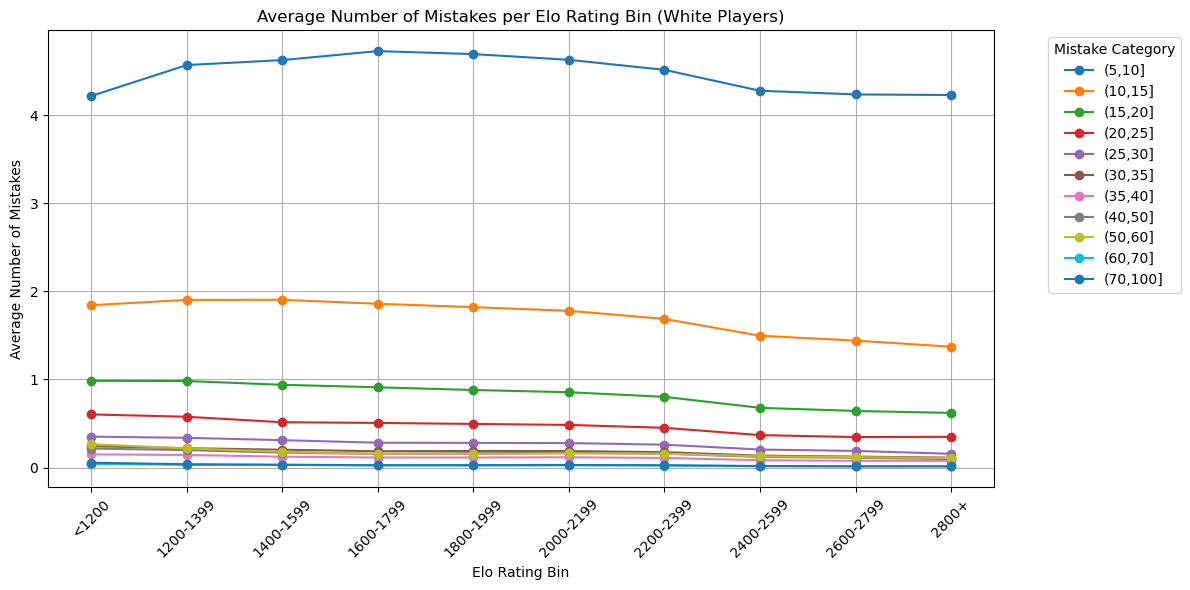

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your summary_table
summary_table = pd.read_csv("../huge_analyzed_games/big_summary_table.csv")

# Filter data for White players only
summary_table_white = summary_table[summary_table['Player'] == 'White']

# Define the mistake intervals and labels
mistake_labels = [
    '(5,10]', '(10,15]', '(15,20]', '(20,25]', '(25,30]',
    '(30,35]', '(35,40]', '(40,50]', '(50,60]', '(60,70]', '(70,100]'
]

# Handle missing values in mistake intervals
summary_table_white[mistake_labels] = summary_table_white[mistake_labels].fillna(0)

# Ensure 'Elo' is numeric
summary_table_white['Elo'] = pd.to_numeric(summary_table_white['Elo'], errors='coerce')

# Remove rows with missing 'Elo' values
summary_table_white = summary_table_white.dropna(subset=['Elo'])

# Step 1: Bin the Elo Ratings
# Define Elo rating bins
elo_bins = [0, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, np.inf]
elo_labels = ['<1200', '1200-1399', '1400-1599', '1600-1799', '1800-1999',
              '2000-2199', '2200-2399', '2400-2599', '2600-2799', '2800+']

# Assign Elo bins to the data
summary_table_white['EloBin'] = pd.cut(
    summary_table_white['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False  # Left-inclusive intervals
)

# Step 2: Aggregate the Data
# Group by EloBin and calculate the average number of mistakes in each category
avg_mistakes_per_bin = summary_table_white.groupby('EloBin')[mistake_labels].mean().reset_index()

# Step 3: Plot the Data
# Set up the plot
plt.figure(figsize=(12, 6))

# Plot a line for each mistake category
for label in mistake_labels:
    plt.plot(
        avg_mistakes_per_bin['EloBin'],
        avg_mistakes_per_bin[label],
        marker='o',
        label=label
    )

# Customize the plot
plt.title('Average Number of Mistakes per Elo Rating Bin (White Players)')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Number of Mistakes')
plt.xticks(rotation=45)
plt.legend(title='Mistake Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [95]:
def calculate_mistake_percentage(summary_table, interval_label):
    """
    Calculates the percentage of games that have at least one mistake in the specified interval.

    Parameters:
    summary_table (pd.DataFrame): The DataFrame containing game summaries.
    interval_label (str): The label of the mistake interval to analyze (e.g., '(25,30]').

    Returns:
    float: The percentage of games with at least one mistake in the specified interval.
    """
    # Check if the interval column exists in the summary table
    if interval_label not in summary_table.columns:
        raise ValueError(f"The interval '{interval_label}' does not exist in the summary table columns.")

    # Total number of games
    total_games = len(summary_table)

    # Number of games with at least one mistake in the specified interval
    games_with_mistake = summary_table[summary_table[interval_label] > 0]
    number_with_mistake = len(games_with_mistake)

    # Compute the percentage
    percentage = (number_with_mistake / total_games) * 100
    print(f"Percentage of games with at least one mistake in {interval_label} interval: {percentage:.2f}%")
    return percentage


In [96]:
calculate_mistake_percentage(summary_table, '(25,30]')

Percentage of games with at least one mistake in (25,30] interval: 20.59%


20.58907891749974